# HuBMAP 2023

competition details: https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature

main idea:

- training with pytorch mask-rcnn

- finetuning with small number of iterations

scope:

- data processing

- training with augmentation

- validation with implemented metric

- better cv split by metadata (idea fom top solutions)

also, a single visualization at [rundown](#rundown) session

In [ ]:
!pwd

/content


In [ ]:
# train with 3 classes: background, blood, glomerulus
# each mask is a 2D array with the same dimentions of the image, every pixel would have a value in [0,1], to get the mask thersholding is needed
# this notebooks is run in colab environment
# although random seed is set, results here were obtained after sevearl experiments so the result is not fully reprodicible
NUM_CLASSES = 3
MASK_THRE = 0.5
ENV = "COLAB"
RANDOM_SEED = 824

In [ ]:
# in colab session, upload five files from faster_rcnn folder
# in own upload faster_rcnn lives in the same folder of notebook
import os
assert os.path.exists("/content/faster_rcnn")

# setup needed files

- kaggle dataset

- faster rcnn scripts

In [ ]:
# update kaggle quietly
!pip install -U -q kaggle

In [ ]:
# write api creditials to specified location then use kaggle api
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json

AUTH_KAGGLE = '{"username":".","key":"."}'
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(AUTH_KAGGLE)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c hubmap-hacking-the-human-vasculature

100% 3.97G/3.97G [03:52<00:00, 17.9MB/s]
100% 3.97G/3.97G [03:52<00:00, 18.3MB/s]


In [ ]:
UNZIPPEDDIR = "/content/hubmap"

In [ ]:
%%time

import os
if not os.path.exists(UNZIPPEDDIR):
    os.makedirs(UNZIPPEDDIR)
!unzip -q "/content/hubmap-hacking-the-human-vasculature.zip" -d "$UNZIPPEDDIR"

CPU times: user 340 ms, sys: 44.4 ms, total: 384 ms
Wall time: 56.9 s


In [ ]:
DATA_DIR = UNZIPPEDDIR
DATA_DIR

'/content/hubmap'

In [ ]:
# get faster rcnn files
# check imports here
from faster_rcnn import utils
from faster_rcnn.coco_eval import CocoEvaluator
from faster_rcnn.coco_utils import get_coco_api_from_dataset

# setup

In [ ]:
import os
import os.path as osp
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import cv2
import matplotlib.image as mpimg
import shutil
from tqdm.auto import tqdm

In [ ]:
import gc
import torch
import torchvision
import random

def clearrubbish():
    torch.cuda.empty_cache()
    gc.collect()

clearrubbish()
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = "cuda:0" if torch.cuda.is_available() else torch.device('cpu')
device

'cuda:0'

In [ ]:
!pip install pycocotools -q

# peek into data

In [ ]:
def df_unique_rows(dfa, dfb):
    "return the rows in dfa that are not present in dfb"
    # https://stackoverflow.com/questions/44706485/how-to-remove-rows-in-a-pandas-dataframe-if-the-same-row-exists-in-another-dataf
    return pd.merge(dfa,dfb, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [ ]:
allnames = glob.glob(osp.join(DATA_DIR, "*"))
print(allnames)

['/content/hubmap/tile_meta.csv', '/content/hubmap/test', '/content/hubmap/wsi_meta.csv', '/content/hubmap/polygons.jsonl', '/content/hubmap/train', '/content/hubmap/sample_submission.csv']


In [ ]:
alljsonpath = osp.join(DATA_DIR, "polygons.jsonl")
alltifdir = osp.join(DATA_DIR, "train")

In [ ]:
tile_meta_df = pd.read_csv(osp.join(DATA_DIR, "tile_meta.csv"))
tile_meta_df

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008
...,...,...,...,...,...
7028,ffd37b5c6598,13,3,13824,21504
7029,ffd3d193c71e,3,2,7680,16896
7030,ffd77e2517af,13,3,15872,28160
7031,ffe3cbb81f72,10,3,15456,23000


In [ ]:
subsetdf = tile_meta_df.loc[tile_meta_df["dataset"].isin([1,2])]
subsetdf.describe()

,source_wsi,dataset,i,j
count,1633.000000,1633.00000,1633.000000,1633.000000
mean,2.272505,1.74158,11514.199633,19736.355175
std,1.073219,0.43790,6565.735338,12142.219076
min,1.000000,1.00000,1536.000000,2560.000000
25%,1.000000,1.00000,6656.000000,10240.000000
50%,2.000000,2.00000,10240.000000,17956.000000
75%,3.000000,2.00000,16384.000000,24064.000000
max,4.000000,2.00000,30208.000000,46592.000000


In [ ]:
table = pd.pivot_table(subsetdf, values=['id'], index=['source_wsi', 'dataset'],
                       aggfunc={'id': np.count_nonzero})
table

id
source_wsi dataset     
1          1        270
           2        237
2          1        152
           2        293
3          2        410
4          2        271

# data processing

In [ ]:
def getidanndict(alljsonpath, subset=[1]):
    "actually, only 1,2 or 12..."
    with open(alljsonpath, "r") as f:
        alljsonlist = list(f)
        # get the ids in subset
        neededids = tile_meta_df.loc[tile_meta_df["dataset"].isin(subset)]["id"].values

        # turn to id-annotations dict
        idanndict = dict()
        for st in tqdm(alljsonlist):
            thisjson = json.loads(st)
            if thisjson["id"] not in neededids: continue
            idanndict[thisjson["id"]] = thisjson["annotations"]

        return idanndict

In [ ]:
import matplotlib.image as mpimg
def getmpimg(id, tifdif):
    tifpath = os.path.join(tifdif, f"{id}.tif")
    return mpimg.imread(tifpath)

class MaskProcessor():
    """acculate mask areas, plt a histogram of that"""
    def __init__(self, minprop=0.0001, side=512, debug=False):
        self.areas = [list(), list()] # for blood_vessel, glo
        self.minprop = minprop
        self.side = side
        self.debug = debug

    def getmask(self, ann):
        """fixed 512*512 size, each blood vessel has decreaing intensity in the combined image!"""
        mask = np.zeros((self.side, self.side), dtype=np.float32)
        glo_mask = np.zeros((self.side, self.side), dtype=np.float32)

        for obj in ann:
            if obj["type"] == "blood_vessel":
                pts = np.array(obj["coordinates"]).squeeze(0)
                for cd in pts:
                    rr, cc = cd[1], cd[0]
                    mask[rr, cc] = 1

            if obj["type"] == "glomerulus":
                pts = np.array(obj["coordinates"]).squeeze(0)
                for cd in pts:
                    rr, cc = cd[1], cd[0]
                    glo_mask[rr, cc] = 1

        theseareas = [list(), list()]

        # handle blood
        contours,_ = cv2.findContours((mask*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        blood_mask = np.zeros([mask.shape[0], mask.shape[1], 3], dtype=np.uint8)

        for i in range(len(contours)):
            c =  contours[i]
            cval = 255 - 2*i
            carea = cv2.contourArea(c, True)
            x,y,w,h = cv2.boundingRect(c)

            if carea < 50:
                continue
            else:
                cv2.drawContours(blood_mask, [c], -1, color=(cval, cval, cval), thickness=cv2.FILLED)
                theseareas[0].append(carea)

        # handle glo
        glo_contours,_ = cv2.findContours((glo_mask*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        glo_res =  np.zeros([mask.shape[0], mask.shape[1], 3], dtype=np.uint8)
        for i in range(len(glo_contours)):
            c =  glo_contours[i]
            cval = 255 - 2*i
            carea = cv2.contourArea(c, True)
            if carea < 50:
                continue
            x,y,w,h = cv2.boundingRect(c)
            cv2.drawContours(glo_res, [c], -1, color=(cval, cval, cval), thickness=cv2.FILLED)
            theseareas[1].append(carea)

        for i in range(len(self.areas)):
            self.areas[i].append(theseareas[i])

        if not self.debug:
            return [blood_mask, glo_res]
        else:
            return [blood_mask, glo_res], [contours, glo_contours]

def preprocess_data(thisidanndict, alltifdir=None, storedir=None, iswrite=True, metadf=None):
    maskprocessor = MaskProcessor(side=512, debug=False)

    # make the needed dirs
    assert storedir is not None
    if not os.path.exists(storedir):
        os.makedirs(storedir)
    dirs = [os.path.join(storedir, "image"),
            os.path.join(storedir, "mask"),
            os.path.join(storedir, "mask_glomerulus")]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)

    writecnt = 0
    writtenids = []
    for id,ann in tqdm(thisidanndict.items()):
        twomasks = maskprocessor.getmask(ann)
        bmask, glomask = twomasks

        if np.sum(bmask) == 0: continue
        else: writtenids.append(id)

        if iswrite:
            bs_maskpath = os.path.join(storedir, "mask", f"{id}.png")
            cv2.imwrite(bs_maskpath, bmask)
            glo_maskpath = os.path.join(storedir, "mask_glomerulus", f"{id}.png")
            cv2.imwrite(glo_maskpath, glomask)

            # copy that tif into folder
            assert alltifdir is not None
            tifpath = os.path.join(alltifdir, f"{id}.tif")
            thisim = getmpimg(id=id, tifdif=alltifdir)
            newimgpath = os.path.join(storedir, "image", f"{id}.png")
            cv2.imwrite(newimgpath, cv2.cvtColor(thisim, cv2.COLOR_RGB2BGR))

    print(f"processed {len(writtenids)} files")
    if iswrite:
        assert metadf is not None
        csvpath = os.path.join(storedir, "meta.csv")
        metadf[metadf.id.isin(writtenids)].to_csv(csvpath, index=False)

    return maskprocessor, writtenids

storedir = "/content/processed_data/newdata_rcnn_new"

alljsonpath = osp.join(DATA_DIR, "polygons.jsonl")
alltifdir = osp.join(DATA_DIR, "train")
tile_meta_df = pd.read_csv(osp.join(DATA_DIR, "tile_meta.csv"))
subsetdf = tile_meta_df.loc[tile_meta_df["dataset"].isin([1,2])]

idanndict_med = getidanndict(alljsonpath = alljsonpath, subset=[1,2])
thisidanndict = idanndict_med
thesekeys = subsetdf["id"].values
subidanndict = {k: thisidanndict[k] for k in thesekeys}

maskprocessor, writtenids =  preprocess_data(subidanndict, alltifdir=alltifdir,
                                             storedir=storedir, iswrite=True, metadf=subsetdf)

  0%|          | 0/1633 [00:00<?, ?it/s]

  0%|          | 0/1633 [00:00<?, ?it/s]

processed 1622 files


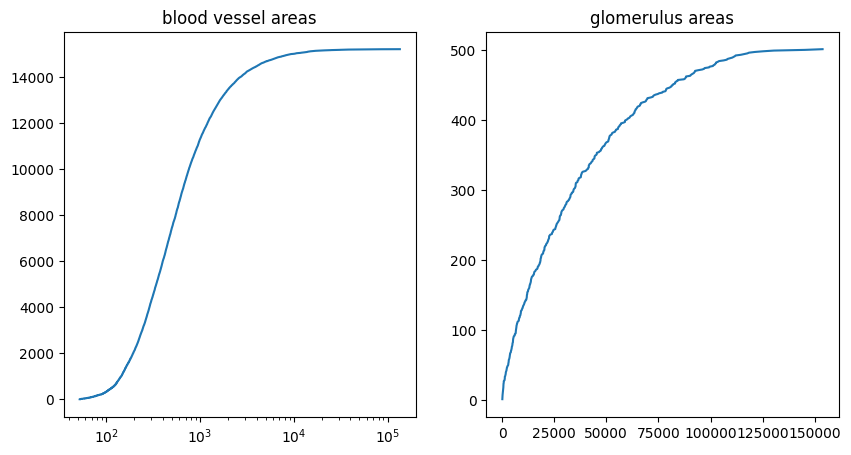

In [ ]:
flattened = list()
for i,arr in enumerate(maskprocessor.areas):
    flattened.append(sorted([x for sub in arr for x in sub]))

# plot culmulative diagrams
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(1,2,1)
plt.plot(flattened[0], 1 + np.arange(len(flattened[0])))
plt.xscale("log")
plt.title("blood vessel areas")

plt.subplot(1,2,2)
plt.plot(flattened[1], 1 + np.arange(len(flattened[1])))
plt.title("glomerulus areas")

plt.show()

# cfg, put into dataframe

load data into cfg nodes to use get/modify methods

In [ ]:
class HuBMAPcfg:
    """take processed data only"""
    def __init__(self, datadir, id):
        self.datadir = datadir
        self.id = id
        self.classnames = ["exception", "mask", "mask_glomerulus"]

    def __getim__(self):
        """get cv2 BGR image"""
        impath = os.path.join(self.datadir, "image", f"{self.id}.png")
        return cv2.imread(impath)

    def __getann__(self):
        """annotation txt"""
        annpath = os.path.join(self.datadir, "annotation", f"{self.id}.txt")
        with open(annpath, "r") as f:
            annstr = f.read()
        return annstr
        
    def __getmaskbyclassnum__(self, classnum):
        maskpath = os.path.join(self.datadir, self.classnames[classnum], f"{self.id}.png")
        return cv2.imread(maskpath)

# dataset, albumentation, train-validation splits

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_album_trans(train=True):
    transforms = []

    if train:
        # v5.2
        transforms.extend([
        A.augmentations.transforms.ImageCompression (quality_lower=99, quality_upper=100, always_apply=False, p=0.8),
        A.augmentations.transforms.PixelDropout (dropout_prob=0.01, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.8),
        A.augmentations.transforms.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.8),
            # ====
        A.augmentations.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3, always_apply=False, p=0.8),
        A.crops.transforms.RandomSizedCrop (min_max_height = (256,512), height=384, width=384, w2h_ratio=1.0, interpolation=1, p=0.6),
        A.augmentations.geometric.resize.RandomScale(scale_limit = (-0.4, 0.4), p=0.8),
        A.HorizontalFlip(p=0.5),
        A.augmentations.geometric.rotate.RandomRotate90(p=0.8),
        ])
    else:
        pass

    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transforms.append(ToTensorV2())
    return A.Compose(transforms)

In [ ]:
from torch.utils.data import Dataset

class HubRcnnDS_Album(Dataset):
    """use Albumentation for augmentation, hence data relation is (image + masks) -> (everything else)
    however after transform there may be some image with bg only, then train with original image-mask pair instead
    accept one of 1. only list of cfgs 2. metainfo dataframe with cfg column, only 2. is used later
    """
    def __init__(self, transforms, cfgs=None, cfgdf=None):
        self._mode = "None"
        self.cfgs = cfgs
        self.cfgdf = cfgdf
        self._deftransforms = get_album_trans(train=False)

        if cfgs is None and cfgdf is None:
            raise Exception("HubRcnnDS_Album: none of cfgs and cfgdf is supplied...")
        elif cfgdf is not None:
            self._mode = "cfgdf"
            self.cfgdf = cfgdf
        else:
            self._mode = "cfgs"
            self.cfgs = cfgs

        assert transforms is not None
        self.transforms = transforms

    def __len__(self):
        if self._mode == "cfgs": return len(self.cfgs)
        return len(self.cfgdf)

    def __getcfg__(self, index):
        if self._mode == "cfgs": return self.cfgs[index]
        return self.cfgdf.iloc[index].cfg

    def __getboxes__(self, allmasks):
        """return boxes of masks, with indices of good boxes (i.e. area > 0)"""
        boxes = []
        goodidxs = []
        for i in range(len(allmasks)):
            pos = torch.nonzero(allmasks[i])
            if pos.shape[0] > 0:
                xmin = torch.min(pos[:, 1])
                xmax = torch.max(pos[:, 1])
                ymin = torch.min(pos[:, 0])
                ymax = torch.max(pos[:, 0])

                boxes.append([xmin, ymin, xmax, ymax])
                if (xmax > xmin and ymax > ymin):
                    goodidxs.append(i)
            else:
                # boxes.append([0,0,1,1])
                pass
        return boxes, goodidxs

    def __fetchitem__(self, thiscfg, thisid, index=None):
        """labels: 0 bg, 1 bv, 2 glo"""
        assert NUM_CLASSES == 3
        allmasks = []
        labels = []

        # image, masks, labels before transform
        thisim = cv2.cvtColor(thiscfg.__getim__(), cv2.COLOR_BGR2RGB)

        for i in range(1, len(thiscfg.classnames)):
            thismaskim = thiscfg.__getmaskbyclassnum__(i)
            thismaskim = thismaskim[:, :, 0]
            assert thismaskim.shape == (512,512)
            obj_ids = np.unique(thismaskim)[1:] # exclude 0 from intensities like [  0, 195, 203, 211, 219, 227, 235, 243, 251]
            split_masks = [np.where(thismaskim == obj_ids[j],1, 0) for j in range(len(obj_ids))]
            for sm in split_masks:
                allmasks.append(sm)
                labels.append(i)
        labels = torch.tensor(labels).to(torch.int64)

        # transform
        transformed = self.transforms(image = thisim, masks=allmasks)
        torchim, transmasks =  transformed["image"], transformed["masks"]

        # bounding boxes, if no good back to original image with default album transform
        boxes, goodidxs = self.__getboxes__(transmasks)
        if len(goodidxs) == 0:
            transformed = self._deftransforms(image=thisim, masks=allmasks)
            torchim, transmasks =  transformed["image"], transformed["masks"]
            boxes, goodidxs = self.__getboxes__(transmasks)
        assert len(goodidxs) > 0

        # transmasks is alreay Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)[goodidxs]
        allmasks = torch.stack(transmasks, dim=0).to(torch.uint8)[goodidxs] # for np: torch.as_tensor(allmasks, dtype=torch.uint8)
        labels = labels[goodidxs]

        # remaining attributes required by rcnn
        image_id = torch.tensor([index if index is not None else 0])
        try:
            areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        except:
            print(f"some error in area of {thisid}")
            areas = torch.ones((len(boxes)), dtype=torch.float32)

        iscrowd = torch.zeros((len(allmasks),), dtype=torch.int64) 

        # wrap up
        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = allmasks
        target["image_id"] = image_id
        target["area"] = torch.as_tensor(areas)
        target["iscrowd"] = iscrowd

        return torchim, target

    def __getitembyid__(self, thisid):
        assert self._mode == "cfgdf"
        thiscfg = self.cfgdf[self.cfgdf.id == thisid].cfg
        return self.__fetchitem__(thiscfg, thisid)

    def __getitem__(self, index):
        thiscfg = self.__getcfg__(index)
        thisid = thiscfg.id
        return self.__fetchitem__(thiscfg, thisid, index=index)

In [ ]:
# load a cfgdf, for testing only
PROCESSED_DIR = "/content/processed_data/newdata_rcnn_new"
csvpath = os.path.join(PROCESSED_DIR, "meta.csv")
metadf = pd.read_csv(csvpath)
metadf["cfg"] = metadf.apply(lambda x: HuBMAPcfg(PROCESSED_DIR, x.id), axis=1)
metadf.head(5)

,id,source_wsi,dataset,i,j,cfg
0,0006ff2aa7cd,2,2,16896,16420,<__main__.HuBMAPcfg object at 0x7a8c7c1bbe80>
1,00168d1b7522,2,2,14848,14884,<__main__.HuBMAPcfg object at 0x7a8c7c1bb7c0>
2,0033bbc76b6b,1,1,10240,43008,<__main__.HuBMAPcfg object at 0x7a8c7c1bb6a0>
3,003504460b3a,3,2,8192,11776,<__main__.HuBMAPcfg object at 0x7a8c7c1bacb0>
4,004daf1cbe75,3,2,6144,11264,<__main__.HuBMAPcfg object at 0x7a8c7c1b9c00>


# model

maskrcnn from pytorch, tutorial at https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes, defweights=True, hidden=256):
    if defweights:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=None, weights_backbone=None)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = hidden # original: 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,  hidden_layer, num_classes)

    return model

def my_collate(batch):
    return tuple(zip(*batch))

# training/validation utility

In [ ]:
# rewrite from faster_rcnn.engine to allow schedulers which step at every batch

import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
from faster_rcnn import utils
from faster_rcnn.coco_eval import CocoEvaluator
from faster_rcnn.coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None, lr_scheduler=None):
    """lr_schduler: steps every batch!"""
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    if lr_scheduler is not None:
        print(header)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [ ]:
def predict_single_valid_maskscore(model, img, exparams=None):
    """return a mask with score"""
    assert NUM_CLASSES == 3
    pred_string = ''
    pred_masks = []
    scores = []

    c,h,w = img.shape
    img = img.to(device).unsqueeze(0)
    pred = model(img)

    for m in range(len(pred[0]['masks'])):
        if pred[0]['labels'][m] != 1:
            continue

        mask = pred[0]['masks'][m].detach().permute(1,2,0).cpu().numpy()
        mask = np.where(mask > MASK_THRE, 1, 0).astype(bool).squeeze(2) # (512,512)
        pred_masks.append(mask)

        score = pred[0]['scores'][m].detach().cpu().numpy()
        scores.append(score)

    return pred_masks, scores

def getgtmasks(target):
    assert NUM_CLASSES == 3
    gt_masks = list()
    for i in range(len(target["masks"])):
        if target["labels"][i] != 1:
            continue
        else:
            e = np.where(target["masks"][i] > MASK_THRE, 1, 0).astype(bool)
            gt_masks.append(e)
    return gt_masks

def form_pred_string(pred_masks, scores):
    pred_string = ""
    firstpred = True
    for mask,score in zip(pred_masks, scores):
        encoded = encode_binary_mask(mask)
        if firstpred:
            pred_string += f"0 {score} {encoded.decode('utf-8')}"
            firstpred = False
        else:
            pred_string += f" 0 {score} {encoded.decode('utf-8')}"
    return pred_string

def dilate_mask(boolmask, times=0):
    intmask = boolmask.astype(np.uint8)
    for i in range(times):
        intmask = cv2.dilate(intmask, kernel=np.array([[0,1,0], [1,1,1], [0,1,0]]).astype(np.uint8))
    return intmask.astype(bool)

def dilate_with_kernel(boolmask, kernel = None):
    npmask = boolmask.astype(np.uint8)
    return cv2.dilate(npmask, kernel=kernel).astype(bool)

## encoding and metric calculator

reference: https://www.kaggle.com/code/itsuki9180/hubmap-inference/notebook

In [ ]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

In [ ]:
import pycocotools.mask as mask_util

def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre

In [ ]:
class MAPCalculatorSingleClass:
    def __init__(self, thresholds=[0.6]):
        self.ious = []
        self.confidences = []
        self.image_ids = []
        self.current_img_id = 0

        self.GT = 0

    def accumulate(self, ious, confidences, num_gt):
        assert len(ious) == len(confidences)
        self.ious.extend([x for x in ious])
        self.confidences.extend(confidences)
        self.image_ids.extend([self.current_img_id]*len(confidences))
        self.current_img_id += 1
        self.GT += num_gt

    def process_pred(self, gt_masks, pred_masks, scores=None):
        enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
        enc_gts = [mask_util.encode(np.asarray(p, order='F')) for p in gt_masks]

        # calculate iou
        assert len(enc_gts) > 0
        if len(enc_gts) > 0:
            ious = mask_util.iou(enc_preds, enc_gts, [0]*len(enc_gts))
        else:
            ious = np.array([[0]]*len(enc_preds))
        # acummulate predictions
        if scores is None:
            scores = np.ones((len(enc_preds)))
        self.accumulate(ious, scores, len(enc_gts))

    def evaluate(self, thresholds=[0.6], vis=False):
        # sort by confidence descending
        sorted_inds = np.argsort(self.confidences)[::-1]

        results = dict()

        for th in thresholds:
            accum_tp = 0
            accum_fp = 0

            TP = []
            FP = []
            list_gts = dict()

            NPREDS = []
            count = 0
            for ind in sorted_inds:
                iou_row = self.ious[ind]
                img_id = self.image_ids[ind]

                matched_inds = np.where(iou_row >= th)[0]
                best_gt_ind = -1
                best_iou = 0
                for gt_ind in matched_inds:
                    iou = iou_row[gt_ind]
                    if iou > best_iou and list_gts.get((img_id, gt_ind)) is None:
                        best_iou = iou
                        best_gt_ind = gt_ind

                if best_gt_ind != -1:
                    list_gts[(img_id, best_gt_ind)] = True
                    accum_tp += 1
                else:
                    accum_fp += 1

                count += 1
                NPREDS.append(count)

                TP.append(accum_tp)
                FP.append(accum_fp)

            PR = []
            REC = []

            for tp, fp in zip(TP, FP):
                pr = tp / (tp+fp)
                rec = tp / self.GT
                PR.append(pr)
                REC.append(rec)

            if vis:
                plt.figure()
                # change dot colors for every 25 predictions to give a better look of impact of high score predictions
                colors = ["b", "g", "r"]
                cidx = 0
                for i in range(0,len(REC), 25):
                    plt.plot(REC[i:i+20], PR[i:i+20], '-o', color=colors[cidx])
                    cidx = (cidx + 1) % 3

            ap, mrec, mpre = voc_ap(REC, PR)

            if vis:
                plt.plot(mrec, mpre, '--', label='interpolation')
                plt.legend()
                plt.title(f'Precision recall curve at threshold:{str(np.round(th, 2))}, tp:{TP[-1]}, fp:{FP[-1]}, gt:{self.GT}')
                plt.show()

                tplen = min(len(TP), 500)
                tprange = np.arange(tplen)
                plt.plot(tprange, TP[:tplen])
                plt.plot(tprange, FP[:tplen])
                plt.title("tp, fp trends")
                plt.show()

                plt.title("score trends")
                plt.plot(tprange, np.array(self.confidences)[sorted_inds][:tplen])
                plt.show()

            results[th] = ap

        return np.mean(list(results.values())), results, [TP, FP, self.GT]

In [ ]:
# these 3 require a metric calculator
def quickpredict_single_valid(model, img, target, thisid, mAP_calc, exp=-1, exparams=None, ts_uniform=None):
    """return a bunch of things...
    now MUST provide a calc
    exp, exparams are used in experiments not shown here
    ts_uniform is for image dilation in postprocessing
    """

    pred_masks, scores = predict_single_valid_maskscore(model, img, exparams = exparams)


    gt_masks = getgtmasks(target)
    calc_masks = []
    for i in range(len(pred_masks)):
        area = np.count_nonzero(pred_masks[i])
        ts = ts_uniform
        calc_masks.append(dilate_mask(pred_masks[i], ts))
    mAP_calc.process_pred(gt_masks, calc_masks, scores=scores)

    pred_string = form_pred_string(calc_masks, scores)

    c,h,w = img.shape
    return pred_string, thisid, h, w

def quickpredict_ds_metric(model, thisds, mAP_calc, exp=-1, exparams=None, ts_uniform=None):
    """expects __getitem__() and __getcfg__() for thisds
    return elements for the csv
    """
    pred_strings = []
    ids = []
    hs = []
    ws = []

    for i in tqdm(range(len(thisds))):
        img, target = thisds.__getitem__(i)
        idx = thisds.__getcfg__(i).id

        bunch = quickpredict_single_valid(model, img, target, idx, mAP_calc, exp=exp, exparams=exparams, ts_uniform=ts_uniform)
        pred_string, thisid, h, w = bunch
        pred_strings.append(pred_string)
        ids.append(thisid)
        hs.append(h)
        ws.append(w)

    return pred_strings, ids, hs, ws

def quickcalc_evaluate(model, validds):
    model.eval()
    map_calc = MAPCalculatorSingleClass()
    bunch = quickpredict_ds_metric(model, validds, mAP_calc = map_calc, ts_uniform=0)
    return map_calc

# rundown

In [ ]:
NUM_CLASSES

3

In [ ]:
PROCESSED_DIR = "/content/processed_data/newdata_rcnn_new"
assert osp.exists(PROCESSED_DIR)

In [ ]:
def get_usual_df(qstr, csvpath):
    metadf = pd.read_csv(csvpath)
    res_df = metadf.query(qstr).copy()
    res_df["cfg"] = res_df.apply(lambda x: HuBMAPcfg(PROCESSED_DIR, x.id), axis=1)
    return res_df

In [ ]:
# define consevative and aggressive albus

import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_album_trans_cons(train=True, p=0.3):
    transforms = []

    if train:
        transforms.extend([
        A.augmentations.transforms.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=p),
        A.augmentations.transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05, always_apply=False, p=p),
        A.crops.transforms.RandomSizedCrop (min_max_height = (384,512), height=384, width=384, w2h_ratio=1.0, interpolation=1, p=0.4),
        A.augmentations.geometric.resize.RandomScale(scale_limit = (-0.2, 0.5), p=p),
        A.HorizontalFlip(p=0.4),
        A.augmentations.geometric.rotate.RandomRotate90(p=p),
        ])
    else:
        pass

    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transforms.append(ToTensorV2())
    return A.Compose(transforms)


In [ ]:
csvpath = os.path.join(PROCESSED_DIR, "meta.csv")
this_albu = get_album_trans_cons

validds_1L = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i < 6656.0", csvpath))
validds_1R = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i >= 6656.0", csvpath))

trainds = torch.utils.data.ConcatDataset([
    HubRcnnDS_Album(transforms = this_albu(train=True, p=0.3), cfgdf=get_usual_df("source_wsi != 1", csvpath)),
])
trainVds = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=get_usual_df("source_wsi != 1 & dataset == 1", csvpath))

print("valid1, valid2, train")
print(len(validds_1L), len(validds_1R), len(trainds))
print("train-verify part")
print(len(trainVds))

traindl = torch.utils.data.DataLoader(trainds, batch_size=4, shuffle=True,
                                      num_workers=2, drop_last=True, collate_fn = my_collate, pin_memory=True)


valid1, valid2, train
124 140 1126
train-verify part
152


  0%|          | 0/20 [00:00<?, ?it/s]

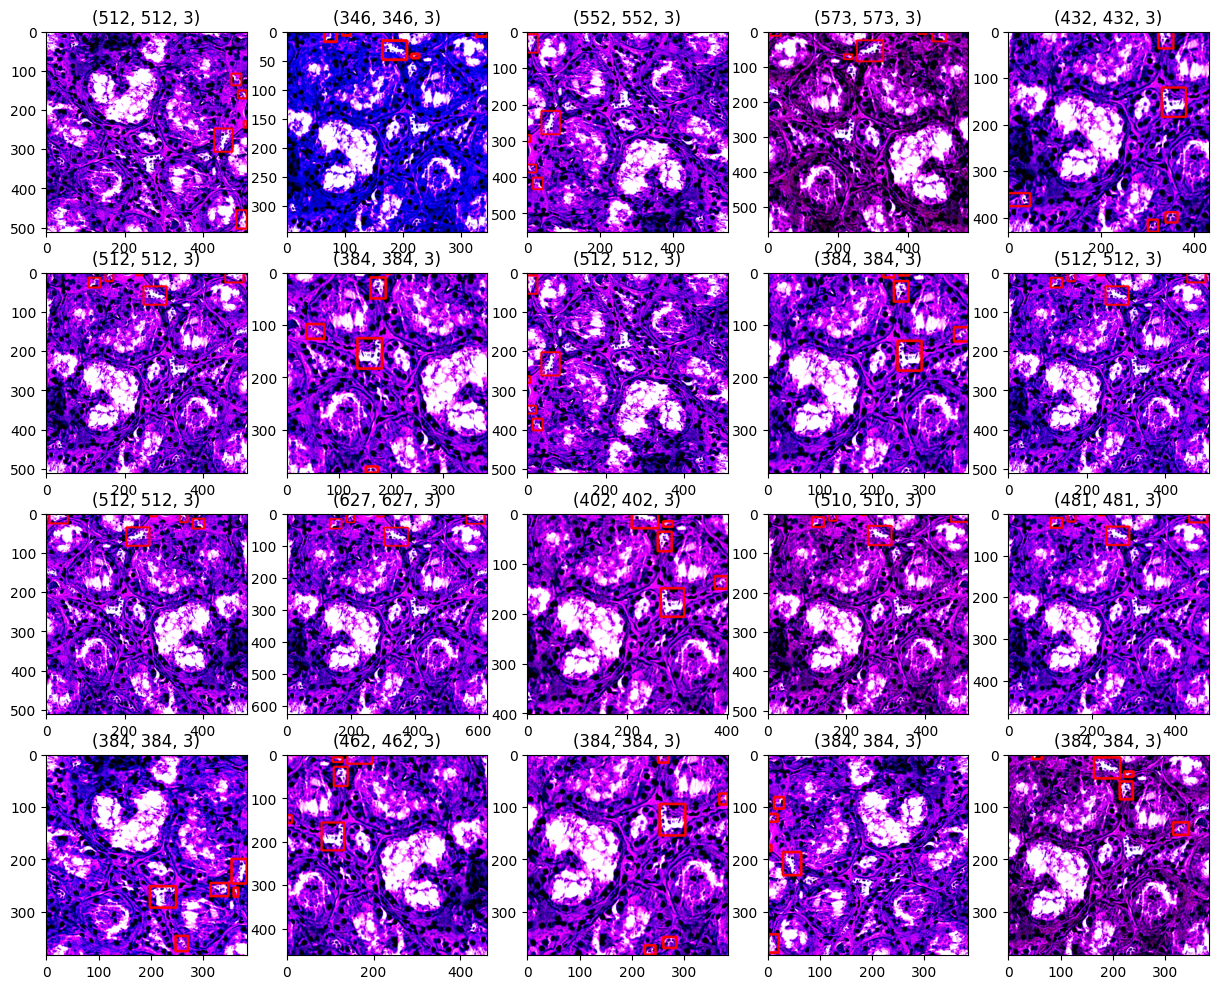

In [ ]:
def plt_im_box(item, numbox=3):
    thisim = item[0].detach().cpu().numpy().transpose(1,2,0)
    bboxes = item[1]["boxes"].detach().cpu().numpy()
    for b in bboxes[:numbox]:
        b = b.astype(np.int32)
        thisim = cv2.rectangle(thisim, (b[0],b[1]), (b[2],b[3]), (255,0,0), 3)
    plt.title(thisim.shape)
    plt.imshow(thisim)

plt.rcParams["figure.figsize"] = (15,12)
for i in tqdm(range(20)):
    plt.subplot(4,5,i+1)
    thisitem = trainds.__getitem__(100)
    plt_im_box(thisitem, numbox=5)
plt.show()

In [ ]:
MODEL_PATH = None

SAVE_NAME = "album-cons"

model = get_model_instance_segmentation(num_classes=NUM_CLASSES, defweights=True, hidden=128)
model.to(device)
if MODEL_PATH is not None:
    print("loading model from", MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH, map_location = device))

params = [p for p in model.parameters() if p.requires_grad]
num_epochs = 8

optimizer = torch.optim.AdamW(params, lr= 1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
# optimizer = torch.optim.AdamW(params, lr= 2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)


# scheduler(s) that step every batch
# this one: both 1e-4 and 3e-4 ok (for Adam...), lr in optimizer would become irrelevant
# scheduler_onecycle = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr = 1e-4, epochs = num_epochs,
#                                                          steps_per_epoch =len(traindl), three_phase=False)
# scheduler_batch = scheduler_onecycle
scheduler_batch = None

# schedulers(s) step per epoch
schedulers_epoch = []


# START
print("num_epochs = ", num_epochs)

model_dir = "/content/maskrcnn_model_transforms" if ENV == "COLAB" else "/kaggle/working/maskrcnn_model_transforms"
print("models will be saved to", model_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def eval_wrapper(model, ds, name):
    print(f"{name} set:")
    map_calc = quickcalc_evaluate(model, ds)
    mAP, detail_scores, varr = map_calc.evaluate(thresholds=[0.6], vis=False)
    TP, FP, gt = varr
    tp = TP[-1]; fp = FP[-1]
    print(f"tp={tp}, fp={fp}, gt={gt}, score={mAP}")

for epoch in range(1, num_epochs+1):
    clearrubbish()

    # train
    freq = 10 if len(traindl) < 50 else 50
    train_one_epoch(model, optimizer, traindl, device, epoch, print_freq=freq, lr_scheduler=scheduler_batch)

    # evaluate at beginning and per 2 ep
    if epoch % 2 == 0 or epoch < 3:
        eval_wrapper(model, validds_1L, "valid-1L")
        eval_wrapper(model, validds_1R, "valid-1R")
        eval_wrapper(model, trainVds, "trainVds")

    # save every epoch
    if epoch % 1 == 0:
        model_path = os.path.join(model_dir, f'{SAVE_NAME}_epoch{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        print("model saved to", model_path)
    for sch in schedulers_epoch:
        sch.step()

print("===============================")
print("done!")

num_epochs =  8
models will be saved to /content/maskrcnn_model_transforms
Epoch: [1]  [  0/281]  eta: 0:09:28  lr: 0.000100  loss: 3.5337 (3.5337)  loss_classifier: 0.8922 (0.8922)  loss_box_reg: 0.1141 (0.1141)  loss_mask: 1.1605 (1.1605)  loss_objectness: 1.2347 (1.2347)  loss_rpn_box_reg: 0.1322 (0.1322)  time: 2.0242  data: 0.7874  max mem: 7109
Epoch: [1]  [ 50/281]  eta: 0:05:17  lr: 0.000100  loss: 1.1946 (1.4165)  loss_classifier: 0.2495 (0.3057)  loss_box_reg: 0.3844 (0.3384)  loss_mask: 0.3635 (0.4553)  loss_objectness: 0.1524 (0.2394)  loss_rpn_box_reg: 0.0817 (0.0777)  time: 1.3551  data: 0.0034  max mem: 7301
Epoch: [1]  [100/281]  eta: 0:04:10  lr: 0.000100  loss: 1.0994 (1.3078)  loss_classifier: 0.2379 (0.2851)  loss_box_reg: 0.3775 (0.3653)  loss_mask: 0.3257 (0.4010)  loss_objectness: 0.0970 (0.1835)  loss_rpn_box_reg: 0.0506 (0.0730)  time: 1.4077  data: 0.0041  max mem: 7355
Epoch: [1]  [150/281]  eta: 0:03:02  lr: 0.000100  loss: 1.1296 (1.2541)  loss_classifier: 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=497, fp=8373, gt=599, score=0.44968986546889994
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=440, fp=9842, gt=581, score=0.3551841413700658
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1894, fp=12823, gt=2312, score=0.5535201899087832
model saved to /content/maskrcnn_model_transforms/album-cons_epoch1.pth
Epoch: [2]  [  0/281]  eta: 0:10:25  lr: 0.000100  loss: 1.1151 (1.1151)  loss_classifier: 0.2428 (0.2428)  loss_box_reg: 0.4630 (0.4630)  loss_mask: 0.3333 (0.3333)  loss_objectness: 0.0566 (0.0566)  loss_rpn_box_reg: 0.0194 (0.0194)  time: 2.2248  data: 0.6763  max mem: 7399
Epoch: [2]  [ 50/281]  eta: 0:05:33  lr: 0.000100  loss: 1.0813 (1.0800)  loss_classifier: 0.2458 (0.2396)  loss_box_reg: 0.4299 (0.4019)  loss_mask: 0.2967 (0.3015)  loss_objectness: 0.0763 (0.0830)  loss_rpn_box_reg: 0.0394 (0.0539)  time: 1.4157  data: 0.0025  max mem: 7399
Epoch: [2]  [100/281]  eta: 0:04:19  lr: 0.000100  loss: 1.0963 (1.0731)  loss_classifier: 0.2469 (0.2416)  loss_box_reg: 0.4187 (0.3995)  loss_mask: 0.3029 (0.3000)  loss_objectness: 0.0700 (0.0782)  loss_rpn_box_reg: 0.0435 (0.0537)  time: 1.4350  data: 0.0018  max mem: 7399
Epoch: [2]  [150/281]  eta: 0:03:07  lr: 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=437, fp=4773, gt=599, score=0.3445631031805978
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=362, fp=5594, gt=581, score=0.23386284931238277
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1937, fp=9443, gt=2312, score=0.5937412230709648
model saved to /content/maskrcnn_model_transforms/album-cons_epoch2.pth
Epoch: [3]  [  0/281]  eta: 0:10:36  lr: 0.000100  loss: 1.1118 (1.1118)  loss_classifier: 0.2411 (0.2411)  loss_box_reg: 0.4537 (0.4537)  loss_mask: 0.2750 (0.2750)  loss_objectness: 0.0783 (0.0783)  loss_rpn_box_reg: 0.0637 (0.0637)  time: 2.2637  data: 0.7177  max mem: 7399
Epoch: [3]  [ 50/281]  eta: 0:05:34  lr: 0.000100  loss: 0.9735 (1.0188)  loss_classifier: 0.2256 (0.2292)  loss_box_reg: 0.3612 (0.3828)  loss_mask: 0.2850 (0.2850)  loss_objectness: 0.0614 (0.0726)  loss_rpn_box_reg: 0.0333 (0.0493)  time: 1.4067  data: 0.0029  max mem: 7399
Epoch: [3]  [100/281]  eta: 0:04:19  lr: 0.000100  loss: 1.0054 (1.0211)  loss_classifier: 0.2158 (0.2308)  loss_box_reg: 0.3776 (0.3867)  loss_mask: 0.2834 (0.2872)  loss_objectness: 0.0542 (0.0691)  loss_rpn_box_reg: 0.0354 (0.0473)  time: 1.4286  data: 0.0027  max mem: 7399
Epoch: [3]  [150/281]  eta: 0:03:07  lr: 0

  0%|          | 0/124 [00:00<?, ?it/s]

tp=478, fp=4734, gt=599, score=0.42492881428827123
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=406, fp=5665, gt=581, score=0.3206404821613137
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1973, fp=11809, gt=2312, score=0.6667822128829591
model saved to /content/maskrcnn_model_transforms/album-cons_epoch4.pth
Epoch: [5]  [  0/281]  eta: 0:10:06  lr: 0.000100  loss: 0.9200 (0.9200)  loss_classifier: 0.1808 (0.1808)  loss_box_reg: 0.3274 (0.3274)  loss_mask: 0.2363 (0.2363)  loss_objectness: 0.0942 (0.0942)  loss_rpn_box_reg: 0.0813 (0.0813)  time: 2.1570  data: 0.6438  max mem: 7399
Epoch: [5]  [ 50/281]  eta: 0:05:34  lr: 0.000100  loss: 0.9155 (0.9836)  loss_classifier: 0.2033 (0.2133)  loss_box_reg: 0.3505 (0.3662)  loss_mask: 0.2738 (0.2763)  loss_objectness: 0.0558 (0.0701)  loss_rpn_box_reg: 0.0389 (0.0578)  time: 1.4107  data: 0.0029  max mem: 7399
Epoch: [5]  [100/281]  eta: 0:04:19  lr: 0.000100  loss: 0.9618 (0.9778)  loss_classifier: 0.2150 (0.2165)  loss_box_reg: 0.3739 (0.3665)  loss_mask: 0.2877 (0.2813)  loss_objectness: 0.0501 (0.0639)  loss_rpn_box_reg: 0.0332 (0.0495)  time: 1.4281  data: 0.0034  max mem: 7399
Epoch: [5]  [150/281]  eta: 0:03:07  lr: 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=469, fp=5627, gt=599, score=0.44899140921318687
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=392, fp=6078, gt=581, score=0.3399270932916657
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=2045, fp=10505, gt=2312, score=0.7143033904633554
model saved to /content/maskrcnn_model_transforms/album-cons_epoch6.pth
Epoch: [7]  [  0/281]  eta: 0:11:36  lr: 0.000100  loss: 0.9240 (0.9240)  loss_classifier: 0.2543 (0.2543)  loss_box_reg: 0.3635 (0.3635)  loss_mask: 0.2363 (0.2363)  loss_objectness: 0.0464 (0.0464)  loss_rpn_box_reg: 0.0235 (0.0235)  time: 2.4770  data: 0.8675  max mem: 7410
Epoch: [7]  [ 50/281]  eta: 0:05:36  lr: 0.000100  loss: 0.9169 (0.9481)  loss_classifier: 0.2062 (0.2165)  loss_box_reg: 0.3434 (0.3591)  loss_mask: 0.2741 (0.2713)  loss_objectness: 0.0495 (0.0558)  loss_rpn_box_reg: 0.0383 (0.0454)  time: 1.4029  data: 0.0029  max mem: 7410
Epoch: [7]  [100/281]  eta: 0:04:21  lr: 0.000100  loss: 0.8723 (0.9364)  loss_classifier: 0.1877 (0.2080)  loss_box_reg: 0.3502 (0.3569)  loss_mask: 0.2744 (0.2741)  loss_objectness: 0.0448 (0.0547)  loss_rpn_box_reg: 0.0334 (0.0427)  time: 1.4408  data: 0.0026  max mem: 7410
Epoch: [7]  [150/281]  eta: 0:03:09  lr: 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=440, fp=2739, gt=599, score=0.434443583672497
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=350, fp=2947, gt=581, score=0.3168086833190767
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=2071, fp=7097, gt=2312, score=0.7578169734408402
model saved to /content/maskrcnn_model_transforms/album-cons_epoch8.pth
done!


In [ ]:
# more aggressive albumentation
def get_album_trans_agg(train=True, p=0.7):
    transforms = []

    if train:
        transforms.extend([
        A.augmentations.transforms.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=p),
        A.crops.transforms.RandomSizedCrop (min_max_height = (256,512), height=384, width=384, w2h_ratio=1.0, interpolation=1, p=0.5),
        A.augmentations.geometric.resize.RandomScale(scale_limit = (-0.3, 0.5), p=p),
        A.HorizontalFlip(p=0.4),
        A.augmentations.geometric.rotate.RandomRotate90(p=0.8),
        ])
    else:
        pass

    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transforms.append(ToTensorV2())
    return A.Compose(transforms)

csvpath = os.path.join(PROCESSED_DIR, "meta.csv")
this_albu = get_album_trans_agg

validds_1L = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i < 6656.0", csvpath))
validds_1R = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i >= 6656.0", csvpath))

trainds = torch.utils.data.ConcatDataset([
    HubRcnnDS_Album(transforms = this_albu(train=True, p=0.8), cfgdf=get_usual_df("source_wsi != 1", csvpath)),
])
trainVds = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=get_usual_df("source_wsi != 1 & dataset == 1", csvpath))

print("valid1, valid2, train")
print(len(validds_1L), len(validds_1R), len(trainds))
print("train-verify part")
print(len(trainVds))

traindl = torch.utils.data.DataLoader(trainds, batch_size=4, shuffle=True,
                                      num_workers=2, drop_last=True, collate_fn = my_collate, pin_memory=False)

# ===========
MODEL_PATH = None

# SAVE_NAME = "album-cons"
SAVE_NAME = "album-agg"


model = get_model_instance_segmentation(num_classes=NUM_CLASSES, defweights=True, hidden=256)
model.to(device)
if MODEL_PATH is not None:
    print("loading model from", MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH, map_location = device))

params = [p for p in model.parameters() if p.requires_grad]
num_epochs = 8

optimizer = torch.optim.AdamW(params, lr= 1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=2e-6)
# optimizer = torch.optim.AdamW(params, lr= 2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

# scheduler(s) that step every batch
scheduler_batch = None

# schedulers(s) step per epoch
schedulers_epoch = []


# START
print("num_epochs = ", num_epochs)

model_dir = "/content/maskrcnn_model_transforms" if ENV == "COLAB" else "/kaggle/working/maskrcnn_model_transforms"
print("models will be saved to", model_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def eval_wrapper(model, ds, name):
    print(f"{name} set:")
    map_calc = quickcalc_evaluate(model, ds)
    mAP, detail_scores, varr = map_calc.evaluate(thresholds=[0.6], vis=False)
    TP, FP, gt = varr
    tp = TP[-1]; fp = FP[-1]
    print(f"tp={tp}, fp={fp}, gt={gt}, score={mAP}")

for epoch in range(1, num_epochs+1):
    clearrubbish()

    # train
    freq = 10 if len(traindl) < 50 else 50
    train_one_epoch(model, optimizer, traindl, device, epoch, print_freq=freq, lr_scheduler=scheduler_batch)

    # evaluate at beginning and per 2 ep
    if epoch % 2 == 0 or epoch < 3:
        eval_wrapper(model, validds_1L, "valid-1L")
        eval_wrapper(model, validds_1R, "valid-1R")
        eval_wrapper(model, trainVds, "trainVds")

    # save every epoch
    if epoch % 1 == 0:
        model_path = os.path.join(model_dir, f'{SAVE_NAME}_epoch{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        print("model saved to", model_path)
    for sch in schedulers_epoch:
        sch.step()

print("===============================")
print("done!")

valid1, valid2, train
124 140 1126
train-verify part
152
num_epochs =  8
models will be saved to /content/maskrcnn_model_transforms
Epoch: [1]  [  0/281]  eta: 0:10:31  lr: 0.000100  loss: 4.5338 (4.5338)  loss_classifier: 1.1117 (1.1117)  loss_box_reg: 0.1325 (0.1325)  loss_mask: 1.4939 (1.4939)  loss_objectness: 1.6133 (1.6133)  loss_rpn_box_reg: 0.1824 (0.1824)  time: 2.2470  data: 0.9724  max mem: 9026
Epoch: [1]  [ 50/281]  eta: 0:05:21  lr: 0.000100  loss: 1.1312 (1.4879)  loss_classifier: 0.2173 (0.2948)  loss_box_reg: 0.3016 (0.2876)  loss_mask: 0.4044 (0.5362)  loss_objectness: 0.1465 (0.2891)  loss_rpn_box_reg: 0.0543 (0.0802)  time: 1.3469  data: 0.0242  max mem: 9026
Epoch: [1]  [100/281]  eta: 0:04:13  lr: 0.000100  loss: 1.2272 (1.3453)  loss_classifier: 0.2648 (0.2813)  loss_box_reg: 0.4515 (0.3275)  loss_mask: 0.3562 (0.4557)  loss_objectness: 0.1027 (0.2100)  loss_rpn_box_reg: 0.0486 (0.0709)  time: 1.4535  data: 0.0246  max mem: 9026
Epoch: [1]  [150/281]  eta: 0:03:0

  0%|          | 0/124 [00:00<?, ?it/s]

tp=418, fp=10164, gt=599, score=0.2677948520364978
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=369, fp=11974, gt=581, score=0.21307083507559516
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1654, fp=13198, gt=2312, score=0.4021294737138097
model saved to /content/maskrcnn_model_transforms/album-agg_epoch1.pth
Epoch: [2]  [  0/281]  eta: 0:10:06  lr: 0.000100  loss: 0.9762 (0.9762)  loss_classifier: 0.2043 (0.2043)  loss_box_reg: 0.2968 (0.2968)  loss_mask: 0.3303 (0.3303)  loss_objectness: 0.0991 (0.0991)  loss_rpn_box_reg: 0.0457 (0.0457)  time: 2.1592  data: 0.6893  max mem: 9026
Epoch: [2]  [ 50/281]  eta: 0:05:39  lr: 0.000100  loss: 1.1455 (1.1306)  loss_classifier: 0.2742 (0.2569)  loss_box_reg: 0.4057 (0.4000)  loss_mask: 0.3259 (0.3266)  loss_objectness: 0.0889 (0.0963)  loss_rpn_box_reg: 0.0400 (0.0507)  time: 1.4372  data: 0.0238  max mem: 9026
Epoch: [2]  [100/281]  eta: 0:04:23  lr: 0.000100  loss: 1.1164 (1.1044)  loss_classifier: 0.2418 (0.2485)  loss_box_reg: 0.3935 (0.3927)  loss_mask: 0.3109 (0.3244)  loss_objectness: 0.0708 (0.0885)  loss_rpn_box_reg: 0.0418 (0.0503)  time: 1.4644  data: 0.0235  max mem: 9026
Epoch: [2]  [150/281]  eta: 0:03:10  lr: 0

  0%|          | 0/124 [00:00<?, ?it/s]

tp=487, fp=6856, gt=599, score=0.40056173542950063
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=408, fp=7940, gt=581, score=0.2844571883141592
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1832, fp=11584, gt=2312, score=0.5121848156218604
model saved to /content/maskrcnn_model_transforms/album-agg_epoch2.pth
Epoch: [3]  [  0/281]  eta: 0:10:13  lr: 0.000100  loss: 0.8995 (0.8995)  loss_classifier: 0.2098 (0.2098)  loss_box_reg: 0.3231 (0.3231)  loss_mask: 0.2622 (0.2622)  loss_objectness: 0.0685 (0.0685)  loss_rpn_box_reg: 0.0359 (0.0359)  time: 2.1840  data: 0.7371  max mem: 9026
Epoch: [3]  [ 50/281]  eta: 0:05:39  lr: 0.000100  loss: 1.0963 (1.0766)  loss_classifier: 0.2289 (0.2425)  loss_box_reg: 0.4038 (0.3781)  loss_mask: 0.3085 (0.3164)  loss_objectness: 0.0659 (0.0861)  loss_rpn_box_reg: 0.0412 (0.0535)  time: 1.4556  data: 0.0249  max mem: 9026
Epoch: [3]  [100/281]  eta: 0:04:23  lr: 0.000100  loss: 0.9670 (1.0657)  loss_classifier: 0.2160 (0.2374)  loss_box_reg: 0.3256 (0.3740)  loss_mask: 0.3118 (0.3174)  loss_objectness: 0.0738 (0.0850)  loss_rpn_box_reg: 0.0388 (0.0518)  time: 1.4270  data: 0.0231  max mem: 9026
Epoch: [3]  [150/281]  eta: 0:03:10  lr: 0

  0%|          | 0/124 [00:00<?, ?it/s]

tp=448, fp=5023, gt=599, score=0.44240828167148133
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=383, fp=6058, gt=581, score=0.3110449522104481
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1911, fp=9849, gt=2312, score=0.6026805845176605
model saved to /content/maskrcnn_model_transforms/album-agg_epoch4.pth
Epoch: [5]  [  0/281]  eta: 0:11:29  lr: 0.000100  loss: 1.3209 (1.3209)  loss_classifier: 0.3043 (0.3043)  loss_box_reg: 0.5409 (0.5409)  loss_mask: 0.3265 (0.3265)  loss_objectness: 0.0991 (0.0991)  loss_rpn_box_reg: 0.0501 (0.0501)  time: 2.4552  data: 0.8197  max mem: 9026
Epoch: [5]  [ 50/281]  eta: 0:05:40  lr: 0.000100  loss: 0.9444 (1.0300)  loss_classifier: 0.2102 (0.2243)  loss_box_reg: 0.3362 (0.3698)  loss_mask: 0.3052 (0.3123)  loss_objectness: 0.0622 (0.0713)  loss_rpn_box_reg: 0.0357 (0.0523)  time: 1.4217  data: 0.0241  max mem: 9026
Epoch: [5]  [100/281]  eta: 0:04:25  lr: 0.000100  loss: 0.9342 (1.0247)  loss_classifier: 0.2165 (0.2254)  loss_box_reg: 0.3452 (0.3696)  loss_mask: 0.3141 (0.3088)  loss_objectness: 0.0609 (0.0698)  loss_rpn_box_reg: 0.0467 (0.0512)  time: 1.4422  data: 0.0232  max mem: 9026
Epoch: [5]  [150/281]  eta: 0:03:11  lr: 0.

  0%|          | 0/124 [00:00<?, ?it/s]

tp=433, fp=4363, gt=599, score=0.39317231573845685
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=369, fp=5133, gt=581, score=0.30478147949889745
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1931, fp=8846, gt=2312, score=0.6163460087235897
model saved to /content/maskrcnn_model_transforms/album-agg_epoch6.pth
Epoch: [7]  [  0/281]  eta: 0:10:04  lr: 0.000100  loss: 0.8263 (0.8263)  loss_classifier: 0.1672 (0.1672)  loss_box_reg: 0.2232 (0.2232)  loss_mask: 0.2323 (0.2323)  loss_objectness: 0.1088 (0.1088)  loss_rpn_box_reg: 0.0948 (0.0948)  time: 2.1500  data: 0.7208  max mem: 9026
Epoch: [7]  [ 50/281]  eta: 0:05:41  lr: 0.000100  loss: 0.9494 (1.0023)  loss_classifier: 0.2094 (0.2212)  loss_box_reg: 0.3309 (0.3611)  loss_mask: 0.3002 (0.2970)  loss_objectness: 0.0558 (0.0681)  loss_rpn_box_reg: 0.0328 (0.0549)  time: 1.4406  data: 0.0249  max mem: 9026
Epoch: [7]  [100/281]  eta: 0:04:25  lr: 0.000100  loss: 1.0405 (1.0168)  loss_classifier: 0.2258 (0.2264)  loss_box_reg: 0.3694 (0.3710)  loss_mask: 0.3102 (0.3040)  loss_objectness: 0.0541 (0.0659)  loss_rpn_box_reg: 0.0308 (0.0494)  time: 1.4575  data: 0.0225  max mem: 9026
Epoch: [7]  [150/281]  eta: 0:03:12  lr: 0.

  0%|          | 0/124 [00:00<?, ?it/s]

tp=434, fp=2835, gt=599, score=0.43421836150706333
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=366, fp=3074, gt=581, score=0.2914911972669965
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1929, fp=7341, gt=2312, score=0.6432916412652929
model saved to /content/maskrcnn_model_transforms/album-agg_epoch8.pth
done!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/kaggle/hubmap/colab_album-agg_epoch8.pth", "/content/maskrcnn_model_transforms/album-agg_epoch8.pth")

'/content/maskrcnn_model_transforms/album-agg_epoch8.pth'

## finetuning with reduced learning rate

In [ ]:
def get_album_trans_agg(train=True, p=0.7):
    transforms = []

    if train:
        transforms.extend([
        A.augmentations.transforms.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        A.augmentations.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=p),
        A.crops.transforms.RandomSizedCrop (min_max_height = (256,512), height=384, width=384, w2h_ratio=1.0, interpolation=1, p=0.5),
        A.augmentations.geometric.resize.RandomScale(scale_limit = (-0.3, 0.5), p=p),
        A.HorizontalFlip(p=0.4),
        A.augmentations.geometric.rotate.RandomRotate90(p=0.8),
        ])
    else:
        pass

    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transforms.append(ToTensorV2())
    return A.Compose(transforms)

csvpath = os.path.join(PROCESSED_DIR, "meta.csv")
this_albu = get_album_trans_agg

validds_1L = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i < 6656.0", csvpath))
validds_1R = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=
                             get_usual_df("source_wsi == 1 & dataset == 1 & i >= 6656.0", csvpath))

trainds = torch.utils.data.ConcatDataset([
    HubRcnnDS_Album(transforms = this_albu(train=True, p=0.8), cfgdf=get_usual_df("source_wsi != 1", csvpath)),
])
trainVds = HubRcnnDS_Album(transforms = this_albu(train=False), cfgdf=get_usual_df("source_wsi != 1 & dataset == 1", csvpath))

print("valid1, valid2, train")
print(len(validds_1L), len(validds_1R), len(trainds))
print("train-verify part")
print(len(trainVds))

traindl = torch.utils.data.DataLoader(trainds, batch_size=4, shuffle=True,
                                      num_workers=2, drop_last=True, collate_fn = my_collate, pin_memory=False)

# ===========
MODEL_PATH = "/content/maskrcnn_model_transforms/album-agg_epoch8.pth"

SAVE_NAME = "album-agg-reduce"


model = get_model_instance_segmentation(num_classes=NUM_CLASSES, defweights=True, hidden=256)
model.to(device)
if MODEL_PATH is not None:
    print("loading model from", MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH, map_location = device))

params = [p for p in model.parameters() if p.requires_grad]
num_epochs = 8

# optimizer = torch.optim.AdamW(params, lr= 1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=2e-6)
optimizer = torch.optim.AdamW(params, lr= 2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

# scheduler(s) that step every batch
scheduler_batch = None

# schedulers(s) step per epoch
schedulers_epoch = []


# START
print("num_epochs = ", num_epochs)

model_dir = "/content/maskrcnn_model_transforms" if ENV == "COLAB" else "/kaggle/working/maskrcnn_model_transforms"
print("models will be saved to", model_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def eval_wrapper(model, ds, name):
    print(f"{name} set:")
    map_calc = quickcalc_evaluate(model, ds)
    mAP, detail_scores, varr = map_calc.evaluate(thresholds=[0.6], vis=False)
    TP, FP, gt = varr
    tp = TP[-1]; fp = FP[-1]
    print(f"tp={tp}, fp={fp}, gt={gt}, score={mAP}")

for epoch in range(1, num_epochs+1):
    clearrubbish()

    # train
    freq = 10 if len(traindl) < 50 else 50
    train_one_epoch(model, optimizer, traindl, device, epoch, print_freq=freq, lr_scheduler=scheduler_batch)

    # evaluate at beginning and per 2 ep
    if epoch % 2 == 0 or epoch < 3:
        eval_wrapper(model, validds_1L, "valid-1L")
        eval_wrapper(model, validds_1R, "valid-1R")
        eval_wrapper(model, trainVds, "trainVds")

    # save every epoch
    if epoch % 1 == 0:
        model_path = os.path.join(model_dir, f'{SAVE_NAME}_epoch{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        print("model saved to", model_path)
    for sch in schedulers_epoch:
        sch.step()

print("===============================")
print("done!")

valid1, valid2, train
124 140 1126
train-verify part
152


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:07<00:00, 24.8MB/s]


loading model from /content/maskrcnn_model_transforms/album-agg_epoch8.pth
num_epochs =  8
models will be saved to /content/maskrcnn_model_transforms
Epoch: [1]  [  0/281]  eta: 0:56:04  lr: 0.000020  loss: 1.4709 (1.4709)  loss_classifier: 0.3936 (0.3936)  loss_box_reg: 0.5187 (0.5187)  loss_mask: 0.2974 (0.2974)  loss_objectness: 0.1704 (0.1704)  loss_rpn_box_reg: 0.0908 (0.0908)  time: 11.9749  data: 1.0797  max mem: 6542
Epoch: [1]  [ 50/281]  eta: 0:05:40  lr: 0.000020  loss: 0.9128 (1.0114)  loss_classifier: 0.2006 (0.2200)  loss_box_reg: 0.3003 (0.3614)  loss_mask: 0.2989 (0.3062)  loss_objectness: 0.0517 (0.0665)  loss_rpn_box_reg: 0.0467 (0.0573)  time: 1.2675  data: 0.0215  max mem: 7097
Epoch: [1]  [100/281]  eta: 0:04:16  lr: 0.000020  loss: 0.9547 (0.9843)  loss_classifier: 0.1944 (0.2100)  loss_box_reg: 0.3340 (0.3524)  loss_mask: 0.2795 (0.2997)  loss_objectness: 0.0615 (0.0696)  loss_rpn_box_reg: 0.0431 (0.0526)  time: 1.4100  data: 0.0255  max mem: 7097
Epoch: [1]  [15

  0%|          | 0/124 [00:00<?, ?it/s]

tp=442, fp=2770, gt=599, score=0.444737919837968
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=386, fp=3180, gt=581, score=0.34745527022784806
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1956, fp=8136, gt=2312, score=0.6535071770321685
model saved to /content/maskrcnn_model_transforms/album-agg-reduce_epoch1.pth
Epoch: [2]  [  0/281]  eta: 0:08:59  lr: 0.000020  loss: 0.8323 (0.8323)  loss_classifier: 0.1810 (0.1810)  loss_box_reg: 0.2875 (0.2875)  loss_mask: 0.3047 (0.3047)  loss_objectness: 0.0374 (0.0374)  loss_rpn_box_reg: 0.0217 (0.0217)  time: 1.9185  data: 0.5660  max mem: 7104
Epoch: [2]  [ 50/281]  eta: 0:05:25  lr: 0.000020  loss: 0.9380 (0.9553)  loss_classifier: 0.2112 (0.2076)  loss_box_reg: 0.3459 (0.3515)  loss_mask: 0.2908 (0.2896)  loss_objectness: 0.0468 (0.0623)  loss_rpn_box_reg: 0.0315 (0.0443)  time: 1.3780  data: 0.0220  max mem: 7104
Epoch: [2]  [100/281]  eta: 0:04:13  lr: 0.000020  loss: 0.9165 (0.9504)  loss_classifier: 0.1851 (0.2053)  loss_box_reg: 0.3483 (0.3512)  loss_mask: 0.2910 (0.2912)  loss_objectness: 0.0521 (0.0595)  loss_rpn_box_reg: 0.0311 (0.0433)  time: 1.3867  data: 0.0224  max mem: 7104
Epoch: [2]  [150/281]  eta: 0:03:02 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=425, fp=2956, gt=599, score=0.4218477998920088
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=373, fp=3491, gt=581, score=0.34214815457142445
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1938, fp=8611, gt=2312, score=0.6457836868697105
model saved to /content/maskrcnn_model_transforms/album-agg-reduce_epoch2.pth
Epoch: [3]  [  0/281]  eta: 0:10:41  lr: 0.000020  loss: 1.0408 (1.0408)  loss_classifier: 0.2406 (0.2406)  loss_box_reg: 0.4021 (0.4021)  loss_mask: 0.2903 (0.2903)  loss_objectness: 0.0351 (0.0351)  loss_rpn_box_reg: 0.0727 (0.0727)  time: 2.2814  data: 0.7575  max mem: 7105
Epoch: [3]  [ 50/281]  eta: 0:05:26  lr: 0.000020  loss: 0.9518 (0.9625)  loss_classifier: 0.2091 (0.2067)  loss_box_reg: 0.3372 (0.3643)  loss_mask: 0.3051 (0.2965)  loss_objectness: 0.0538 (0.0548)  loss_rpn_box_reg: 0.0319 (0.0402)  time: 1.3899  data: 0.0223  max mem: 7105
Epoch: [3]  [100/281]  eta: 0:04:13  lr: 0.000020  loss: 0.9974 (0.9514)  loss_classifier: 0.2154 (0.2035)  loss_box_reg: 0.3841 (0.3548)  loss_mask: 0.2961 (0.2944)  loss_objectness: 0.0504 (0.0573)  loss_rpn_box_reg: 0.0397 (0.0414)  time: 1.4042  data: 0.0223  max mem: 7105
Epoch: [3]  [150/281]  eta: 0:03:03 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=440, fp=2454, gt=599, score=0.470759506855342
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=366, fp=2689, gt=581, score=0.3557980883797034
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=2017, fp=8007, gt=2312, score=0.6959916669089096
model saved to /content/maskrcnn_model_transforms/album-agg-reduce_epoch4.pth
Epoch: [5]  [  0/281]  eta: 0:10:23  lr: 0.000020  loss: 1.1736 (1.1736)  loss_classifier: 0.2889 (0.2889)  loss_box_reg: 0.4012 (0.4012)  loss_mask: 0.2938 (0.2938)  loss_objectness: 0.0928 (0.0928)  loss_rpn_box_reg: 0.0968 (0.0968)  time: 2.2172  data: 0.7907  max mem: 7105
Epoch: [5]  [ 50/281]  eta: 0:05:24  lr: 0.000020  loss: 0.8489 (0.9089)  loss_classifier: 0.1776 (0.1890)  loss_box_reg: 0.3205 (0.3303)  loss_mask: 0.2890 (0.2919)  loss_objectness: 0.0422 (0.0542)  loss_rpn_box_reg: 0.0227 (0.0436)  time: 1.3698  data: 0.0240  max mem: 7112
Epoch: [5]  [100/281]  eta: 0:04:13  lr: 0.000020  loss: 0.9439 (0.9174)  loss_classifier: 0.1895 (0.1936)  loss_box_reg: 0.3559 (0.3374)  loss_mask: 0.2755 (0.2870)  loss_objectness: 0.0473 (0.0553)  loss_rpn_box_reg: 0.0341 (0.0443)  time: 1.4018  data: 0.0226  max mem: 7112
Epoch: [5]  [150/281]  eta: 0:03:03 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=413, fp=2370, gt=599, score=0.42967519592692427
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=375, fp=2706, gt=581, score=0.34661220835320344
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=2011, fp=7502, gt=2312, score=0.7030697448174452
model saved to /content/maskrcnn_model_transforms/album-agg-reduce_epoch6.pth
Epoch: [7]  [  0/281]  eta: 0:09:58  lr: 0.000020  loss: 1.0387 (1.0387)  loss_classifier: 0.2056 (0.2056)  loss_box_reg: 0.3433 (0.3433)  loss_mask: 0.3466 (0.3466)  loss_objectness: 0.0823 (0.0823)  loss_rpn_box_reg: 0.0609 (0.0609)  time: 2.1289  data: 0.6495  max mem: 7112
Epoch: [7]  [ 50/281]  eta: 0:05:25  lr: 0.000020  loss: 0.8979 (0.9185)  loss_classifier: 0.2016 (0.1961)  loss_box_reg: 0.3429 (0.3462)  loss_mask: 0.2712 (0.2832)  loss_objectness: 0.0481 (0.0533)  loss_rpn_box_reg: 0.0313 (0.0397)  time: 1.3846  data: 0.0218  max mem: 7112
Epoch: [7]  [100/281]  eta: 0:04:13  lr: 0.000020  loss: 0.9336 (0.9321)  loss_classifier: 0.1873 (0.1992)  loss_box_reg: 0.3437 (0.3448)  loss_mask: 0.2807 (0.2840)  loss_objectness: 0.0460 (0.0571)  loss_rpn_box_reg: 0.0266 (0.0471)  time: 1.3876  data: 0.0226  max mem: 7112
Epoch: [7]  [150/281]  eta: 0:03:03 

  0%|          | 0/124 [00:00<?, ?it/s]

tp=445, fp=2344, gt=599, score=0.4925896103988256
valid-1R set:


  0%|          | 0/140 [00:00<?, ?it/s]

tp=371, fp=2669, gt=581, score=0.3766536993745084
trainVds set:


  0%|          | 0/152 [00:00<?, ?it/s]

tp=1997, fp=7087, gt=2312, score=0.7062285142966057
model saved to /content/maskrcnn_model_transforms/album-agg-reduce_epoch8.pth
done!


# load back and eval

for the 3 visualizations:

1. precision-recall curve, the area bounded under the cruve is the score

2. cumulative hit-and-miss numbers of highest score predictions

3. the actual scores of highest score predictions

for dilation (by setting ts_uniform > 0):

- a lot of discussion at kaggle during the competition due to siginificant improvement in public leaderboard and some cross-validation work

- use cv2 implementation, dilate the prediction a number of times on validation set

- results here shows a boost at 2 times, but in general this has mixed results (and seen from submission scores)

observations:

- (also from training logs) the performance between left and right parts of the validation set is mostly consistent 

- for right part, the model is not very sure about its predictions (the 500 highest scores has minimum 0.7 instead of 0.8 of the left), and corresponding performance is worse

- avoiding high score negative might be useful

In [ ]:
MODEL_PATH = "/content/maskrcnn_model_transforms/album-agg-reduce_epoch8.pth"
print(device)
model = get_model_instance_segmentation(num_classes=NUM_CLASSES, defweights=False)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location = device))

cuda:0


<All keys matched successfully>

In [ ]:
model.eval()
"ok"

'ok'

In [ ]:
MASK_THRE = 0.5
plt.rcParams["figure.figsize"] = (10,6)
mAP_calc = MAPCalculatorSingleClass()

thisds = validds_1L
# thisds= validds_1R
bunch = quickpredict_ds_metric(model, thisds, mAP_calc, exp=-1, exparams=None, ts_uniform=2)

pred_strings, ids, hs, ws = bunch
mAP, detail_scores, varr = mAP_calc.evaluate(thresholds=[0.6], vis=False)
print('CV (mAP@0.6):', mAP)

  0%|          | 0/124 [00:00<?, ?it/s]

CV (mAP@0.6): 0.6012872143347301


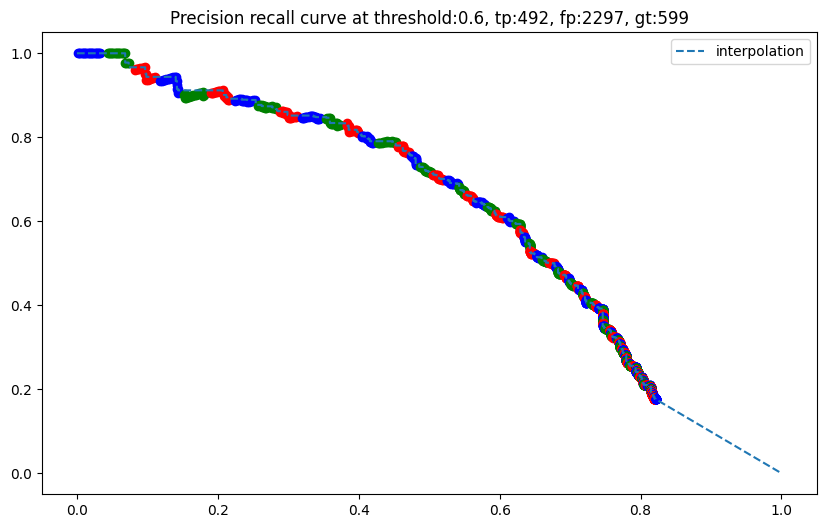

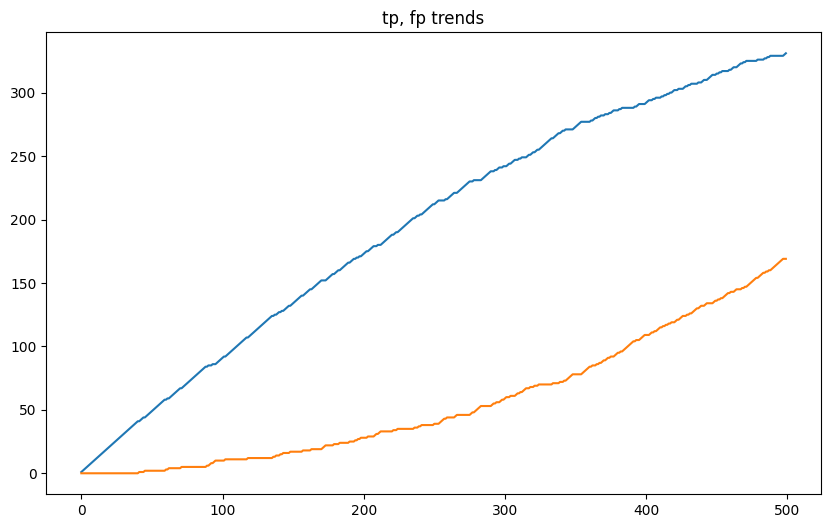

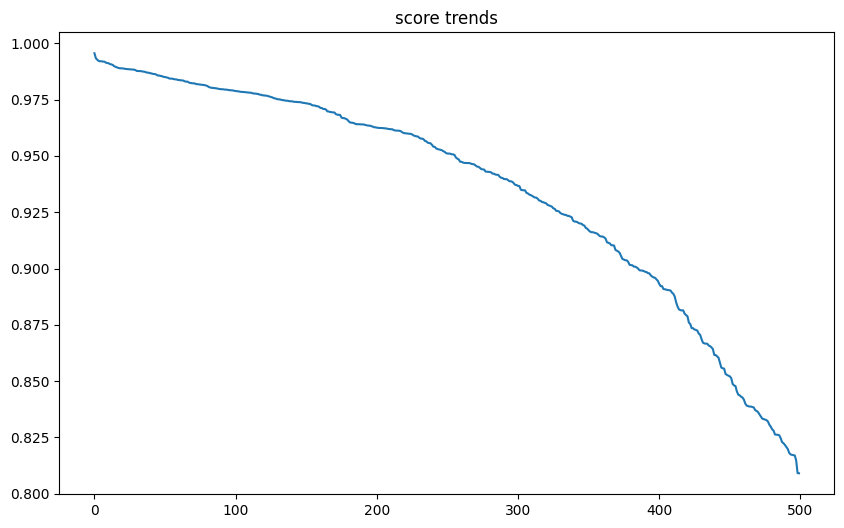

CV (mAP@0.6): 0.6012872143347301


In [ ]:
mAP, detail_scores, varr = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

In [ ]:
MASK_THRE = 0.5
plt.rcParams["figure.figsize"] = (10,6)
mAP_calc = MAPCalculatorSingleClass()

# thisds = validds_1L
thisds= validds_1R
bunch = quickpredict_ds_metric(model, thisds, mAP_calc, exp=-1, exparams=None, ts_uniform=2)

pred_strings, ids, hs, ws = bunch
mAP, detail_scores, varr = mAP_calc.evaluate(thresholds=[0.6], vis=False)
print('CV (mAP@0.6):', mAP)

  0%|          | 0/140 [00:00<?, ?it/s]

CV (mAP@0.6): 0.4541495166330911


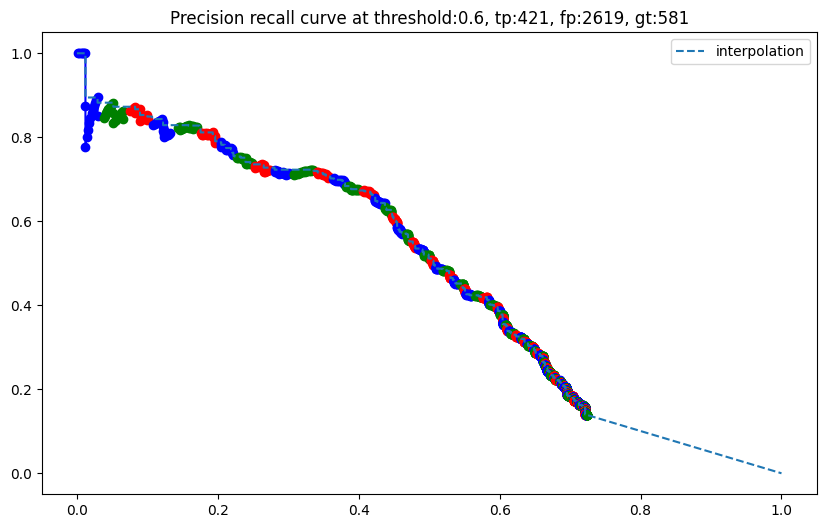

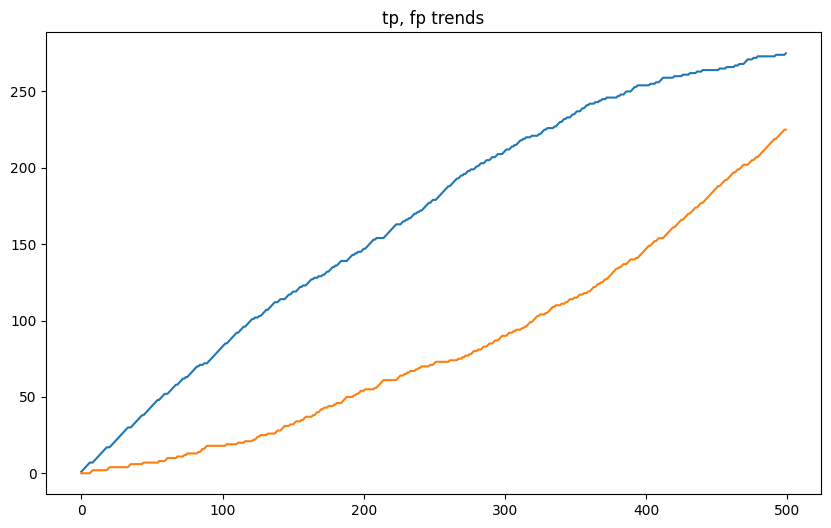

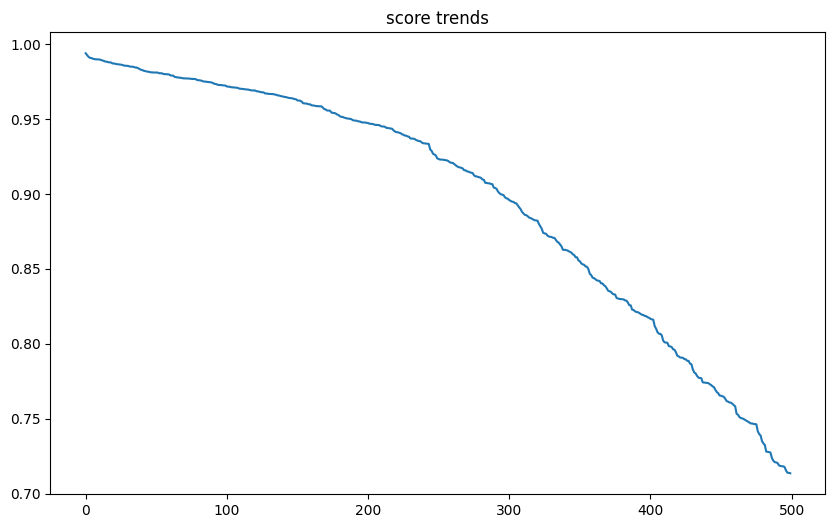

CV (mAP@0.6): 0.4541495166330911


In [ ]:
mAP, detail_scores, varr = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

# final scores

notations:

- cons: conservative training set at epoch 8

- agg: aggressive training set at epoch 8

- agg-finetune: tune with 8 more epochs from agg

- -dilate2: apply dilation for 2 times

| model\score  | public LB | private LB |
|--------------|-----------|------------|
| cons         |0.387|0.418|
| agg          |0.454|0.470|
| cons-dilate2 |0.463|0.274|
| agg-dilate2  |0.477|0.303|
| agg-finetune |0.408|0.487|

observations:

- heavier augmentation is better

- dilation is set-specific: for testing sets of different distributions, may give drastic increase/decrase in performance

- finetuing may be useful, but model performance still fluctuates, also seen from finetuning logs above